# Linear Time Iteration

The details of solving rational expectations models are somewhat tricky. Yet, a paper by [Pontus Rendahl](https://sites.google.com/site/pontusrendahl/) underlines that an easy (and fast) method exists. What's more, this method seems to be adapted to regime switching models and to models with a large state variable. The last point is particularly relevant if one works with heterogeneous agents models and uses Reiter (2009) method to solve them. In this post, I describe the method (closely following the paper) and give simple examples in Julia. 

## Intuition

Below, I quote some fundamental passages from the paper, discussing the intuition of the method:

> "The logic underlying the procedure is simple enough to be described in words. Envisage an agent having a certain amount of an asset, facing the choice between how much of this asset to **consume and how much to save**. An optimal choice would **trade off the marginal benefit of saving (future consumption) with its marginal cost (forgone current consumption)**. The resulting optimal decision is implied by a linear(ized) second-order difference equation"

> "[...] the future marginal benefit of saving depends on **the optimal saving choice in the future**. Thus, an optimal choice today can only be determined underthe condition that the optimal choice in **the future is known**; thus the problem amounts to **finding a fixed point**. To solve this problem, this paper proposes to **guess for the optimal choice** of saving in the future as a **linear function of the associated state** (which is given by the optimal choice in thepresent). Given such a guess, the optimal choice in the present is then trivially given by solving a linear equation. However, the current optimal choice provides us with another suggestion regarding future optimal behavior, and the guess is updated accordingly."

To summarize (i) solving a rational expectations model is intrinsically a fixed-point problem (ii) the Linear Time Iteration approach assumes a particular form for the solution of the problem and iterates the solution forward. The paper makes sure that this procedure converges and is well behaved.

## The Method

We are interested in solving a model of the form:

$$ A x_{t-1} + B x_{t} + C E_{t} [x_{t+1}] + u_{t} = 0 $$ 

Where $x_t$ is an n × 1 vector containing endogenous and exogenous variables, $u_t$ is an n × 1 vector of mean-zero disturbances, and $A$, $B$ and $C$ are conformable matrices.

Let us assume that the solution is:

 $$ x_{t} = F x_{t-1} + Q u_{t} $$

where $F$ and $Q$ are unknown matrices.

Substituting the linear law of motion into the first equation (and using the fact that $u_{t+1}$ is a mean-zero random noise term) yields:

$$ A x_{t−1} + B x_{t} + CF x_{t} + u_{t} = 0. $$ 

This equation can be written as:

$$ x_{t} = -(B + CF)^{-1} A x_{t−1} + (-(B + CF)^{-1})u_t $$ 

Comparing the solution we assumed in the first place, and the last equation, we see that:

$$ Q = -(B + CF)^{-1}$$ 

The previous manipulations show that if one knows $F$, finding $Q$ is trivial (because $B$ and $C$ are known).
In practical terms, we can focus on solving the deterministic part of the problem (ignoring the $u_t$), since
we can then back out the stochastic solution using our equation for $Q$.

The deterministic problem is:

$$ A x_{t-1} + B x_{t} + C x_{t+1}  = 0 $$ 

And its associated solution is:

$$ x_{t} = F x_{t-1} $$

Now let's guess a value for $F$, denoted by $F_{n}$.

A simple substitution gives:

$$ A x_{t-1} + B x_{t} + F_{n} C x_{t}  = 0 $$ 

Which can be re-written as:

$$ x_{t}  = - (B + F_{n} C)^{-1}A x_{t-1}  $$ 

Comparing the solution we assumed in the first place and the last equation, the following **updating rule** seems to make sense:

$$ F_{n+1} = - (B + F_{n} C)^{-1} A $$ 

One could apply the updating rule until the distance between $F_{n+1}$ and $F_{n}$ is small, but the paper uses
another stopping rule. Let's start with an observation and then give a definition:

#### Fact

If $F$ solves 

$$ A x_{t−1} + B x_{t} + CF x_{t} = 0. $$ 

then $F$ solves the quadratic matrix equation:

$$ A + B F + C F^2 = 0 $$

#### Definition

A solution to the equation $$ A + B F + C F^2 = 0 $$ is called a **solvent**.

We now have all the elements to describe the Linear Time Iteration algorithm.

#### Algorithm

* Guess a value for $F_0$
* Calculate $ F_{1} = - (B + F_{0} C)^{-1} A $
* If $ || A + B F_1 + C F_1^2 || < tol $ stop. $F_1$ is a solvent
* Else, increment the index for $F$ and start again

If all the eigenvalues of the resulting solvent are less than $1$ in absolute value, then we found a stable solution
to the quadratic matrix equation. However, is is not necessarily the unique stable solution. For discussion on uniqueness and stability, an interested reader may refer to proposition 2 of the paper. 

## Examples

Let's now see how the Linear Time Iteration performs on two simple examples described in the original paper.

### Example 1: a uni-dimensional example

$$ 0.75 x_{t−1} − 2 x_{t} + x_{t+1} = 0 $$

In this example, using Linear Time Iteration is clearly an overkill since we can calculate the solution by hand. 
The two solvents are $1.5$ and $0.5$. As we will see, the method laid above converges to the smaller of the two values.

In [1]:
versioninfo()

Julia Version 1.0.3
Commit 099e826241 (2018-12-18 01:34 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.0 (ORCJIT, skylake)


In [2]:
# Parameters
a = 0.75
b = -2.0
c = 1.0
# Tolerance
tol = 1e-6
# Maximum iterations
max_iter = 1000
# Initial guess for F
F_n = 0.0

0.0

In [3]:
for i=1:max_iter
    # Updating rule:
    F_n_new =  -a*(1/(b + F_n*c))
    # Stopping rule:
    if abs(a + b *F_n_new + c*F_n_new^2) < tol 
        println("convergence after $i iterations")
        println("final value for F is $F_n")
        break
    end
    F_n = copy(F_n_new)
    if i == max_iter
        println("convergence NOT reached $i iterations")
    end
end
    

convergence after 12 iterations
final value for F is 0.4999981183200362


### Dealing with singular solvents

Even in some reasonable cases, the simple Linear Time Iteration algorithm described above might fail. For instance, because the model contains accounting identities, in which case the solvent may be "singular".

#### Definition

A solvent is **singular** if it cotains at least one eigenvalue equal to 1.

Fortunately, a simple trick extends the Linear Time Iteration method to singular solvents.
One solves the modified quadratic matrix equation

$$ \hat{A} S^2 + \hat{B} S + \hat{C} = 0 $$


where 

$$ \hat{A} = C M^2 + B M + A $$
$$ \hat{B} = B + 2 C M$$
$$ \hat{C} = C$$
$$ M = \mu I $$

with $\mu$ a small positive real number and $I$ a conformable identity matrix. If the Linear Time Iteration
algorithm applied to the modified system converges to $S$, the $F = S + M$ is solution to the original system. 
Below I define a function `t_iteration` the solves the modified system

In [4]:
using LinearAlgebra

# Source: adapted from the matlab version made available by Pontus Rendahl on his website
# https://sites.google.com/site/pontusrendahl/Research
# This function solves the model Ax_{t-1}+Bx_{t}+CE_t[x_{t+1}]+u_t=0, and
# finds the solution x_t=Fx_{t-1}+Qu_t. The parameter mu should be set
# equal to a small number, e.g. mu=1e-6;

function t_iteration(A::Array{Float64,2}, 
                    B::Array{Float64,2}, 
                    C::Array{Float64,2}, 
                    mu::Float64;
                    tol::Float64=1e-12,
                    max_iter::Int64 = 1000,
                    F0::Array{Float64,2} = Array{Float64}(undef, 0, 0),
                    S0::Array{Float64,2} = Array{Float64}(undef, 0, 0),
                    verbose::Bool=false)

# success flag:
flag = 0
    
# Initialization
dim = size(A,2)
if isempty(F0) == true
    F = zeros(dim,dim)
else
    F = F0
end
if isempty(S0) == true
    S = zeros(dim,dim)
else
    S = S0
end

eye = zeros(dim,dim)
for i = 1:dim
    eye[i,i] = 1.0
end
    
I = eye*mu
Ch = C
Bh = (B+C*2*I)
Ah = (C*I^2+B*I+A)

#Check the reciprocal condition number
#if rcond(Ah)<1e-16
#    disp('Matrix Ah is singular')
#end

metric = 1;
nb_iter = 0
    
while metric>tol
    nb_iter+=1
    #\(x, y)
    #Left division operator: 
    #multiplication of y by the inverse of x on the left. 
    F = -(Bh+Ch*F)\Ah
    S = -(Bh+Ah*S)\Ch;
    
    metric1 = maximum(abs.(Ah+Bh*F+Ch*F*F))
    metric2 = maximum(abs.(Ah*S*S+Bh*S+Ch))
    metric = max(metric1, metric2)
        
    if nb_iter == max_iter
        if verbose == true
            print("Maximum number of iterations reached. Convergence not reached.")
            print("metric = $metric")
        end
        break
    end
end


eig_F = maximum(abs.(eigvals(F)));
eig_S = maximum(abs.(eigvals(S)));
    
if eig_F>1 || eig_S>1 || mu>1-eig_S
    if verbose == true
        println("Conditions of Proposition 3 violated")
    end
else
    flag = 1
end

F = F+I;
Q = -inv(B+C*F);

return F, Q, flag
    
end


t_iteration (generic function with 1 method)

### Example 2: a bi-dimensional problem

The problem is 

$$ 0.75 y_t - 0.5 y_{t+1} = 0 $$
$$ -2 x_t + x_{t-1} - y_{t} = 0 $$

This problem has three solvents. Two of them lead to unstable solution. The solvent associated to a stable solution is given by:

$$   S = \begin{bmatrix}
    0 & 0 \\
    0 & 0.5 
  \end{bmatrix}$$ 

Solvent is :[0.0 0.0; 0.0 0.5]


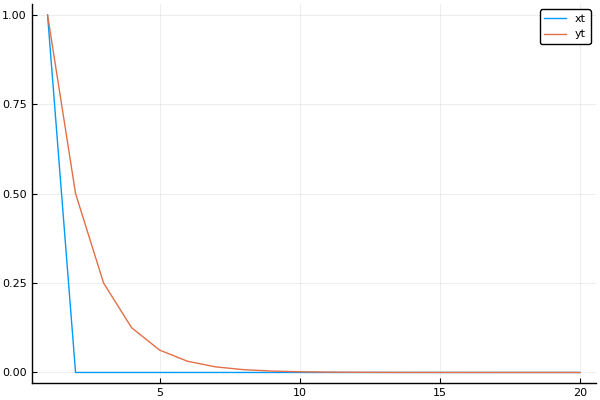

In [5]:
# Defining the problem
A = [[0. 0.];
     [0. 1.]]

B = [[0.75 0.];
     [-1. -2.]]

C = [[-0.5 0.];
     [0. 0.]]

# Finding a solvent
F_n, Q_n, flag = t_iteration(A, B, C, 0.01, max_iter=1000)

println("Solvent is :", F_n)

# Simulating the model forward
using Plots
pyplot()

nb_periods = 20
x = ones(2, nb_periods)
#initialization
x[:,1] = [1.0 1.0] #starting value

for t=2:nb_periods
    # Update rule
    x[:,t] = F_n * x[:,t-1]
end

plot(x[1,:], label = "xt")
plot!(x[2,:], label = "yt")

## Conclusion

Linear Time Iteration is an intuitive an easily applicable method to solve (linear) rational expectations models. This post aimed at describing the intuition for it and give simple examples. In a subsequent post, I will use this technique to solve the stochastic growth model.

### References

* Rendahl, Pontus. Linear time iteration. No. 330. IHS Economics Series, 2017.
(https://www.ihs.ac.at/publications/eco/es-330.pdf)
* Reiter, Michael. "Solving heterogeneous-agent models by projection and perturbation." Journal of Economic Dynamics and Control 33.3 (2009): 649-665.